<a href="https://colab.research.google.com/github/federicOO1/LAB-IA/blob/main/test_progetto_LAB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import librerie


In [1]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms, utils
import torch.nn as nn
import os
import albumentations as A
import numpy as np
import PIL
import torch.nn.functional as F
import warnings
from tqdm.auto import tqdm
import torch.utils.checkpoint as checkpoint
from albumentations.pytorch import ToTensorV2
import torch.optim as optim
import shutil
import random
import albumentations
!pip install rasterio
import rasterio
from rasterio.plot import reshape_as_image

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 69.7 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/task1/Potsdam')

Mounted at /content/drive


In [3]:
class PotsdamDataset(Dataset):
    def __init__(self, images_folder, labels_folder, train_val_test, transform=None, mean=None, std=None, size=None):
        self.images_folder = images_folder
        self.labels_folder = labels_folder
        self.train_val_test = train_val_test
        self.image_paths = []
        self.world_file_paths = []
        self.mask_paths = []
        self.transform = transform
        self.mean = mean
        self.std = std
        self.size = size
        self.normalize = transforms.Normalize(mean=mean, std=std)


        img_folder = os.path.join(self.images_folder, train_val_test)
        lbl_folder = os.path.join(self.labels_folder, train_val_test)

        for file_name in os.listdir(img_folder):
          if file_name.endswith('.tif'):
              image_path = os.path.join(img_folder, file_name)
              self.image_paths.append(image_path)
              world_file_path = os.path.join(img_folder, file_name.replace('.tif', '.tfw'))
              if os.path.exists(world_file_path):
                            self.world_file_paths.append(world_file_path)

        for label_name in os.listdir(lbl_folder):
                    mask_path = os.path.join(lbl_folder, label_name)
                    if os.path.exists(mask_path):
                      self.mask_paths.append(mask_path)

        self.image_paths.sort()
        self.world_file_paths.sort()
        self.mask_paths.sort()

    def __len__(self):
        return len(self.image_paths)

    def get_image_paths(self, indices):
        return [self.image_paths[idx] for idx in indices]

    def get_mask_paths(self, indices):
        return [self.mask_paths[idx] for idx in indices]

    def load_world_file(self, world_file_path):
          lines = open(world_file_path).readlines()
          try:
              parameters = [float(line.strip()) for line in lines if line.strip()]
              if len(parameters) == 6:
                  return parameters
              else:
                  raise ValueError("Il file .tfw non contiene 6 parametri.")
          except Exception as e:
              print(f"Errore durante la lettura dei parametri di georeferenziazione: {str(e)}")
              return None

    def RGB_to_class(self, rgb_label):
        # Mappa colori con classe
        colors_to_labels = {
            (255, 255, 255): 0,
            (0, 0, 255): 1,
            (0, 255, 255): 2,
            (0, 255, 0): 3,
            (255, 255, 0): 4,
            (255, 0, 0): 5
        }

        # Trasponi l'array per avere le dimensioni (6000, 6000, 3)
        transposed_label = np.transpose(rgb_label, (1, 2, 0))

        class_label = np.zeros((6000, 6000), dtype=np.int64)

        for color, label in colors_to_labels.items():
            #print("np.array(color).reshape(1, 1, 3)",np.array(color).reshape(1, 1, 3))
            #print("\n\n\n trasp_label:",transposed_label)
            mask = np.all(transposed_label == np.array(color).reshape(1, 1, 3), axis=-1)
            #print("mask:",mask)
            class_label[mask] = label
            #print("\n\n\n class_label:",class_label)

        #class_label_tensor = torch.tensor(class_label, dtype=torch.long)

        return class_label

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        world_file_path = self.world_file_paths[idx]
        mask_path = self.mask_paths[idx]

        image = rasterio.open(image_path).read()

        world_params = self.load_world_file(world_file_path)

        mask = rasterio.open(mask_path).read()

        label = self.RGB_to_class(mask)

        if self.transform is not None:
            # Transponi l'immagine per avere le dimensioni (C, H, W)
            #print("1",image.shape)
            image = image.transpose(1, 2, 0)
            #print("image:",image.shape,"label:",label.shape)
            augmented = self.transform(image=image,mask=label)
            image = augmented['image'].numpy()
            label = augmented['mask'].numpy()
            #print("image:",image.shape,"label:",label.shape)

        return image, label


Codice di test per verificare la correttezza della data augmentation

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


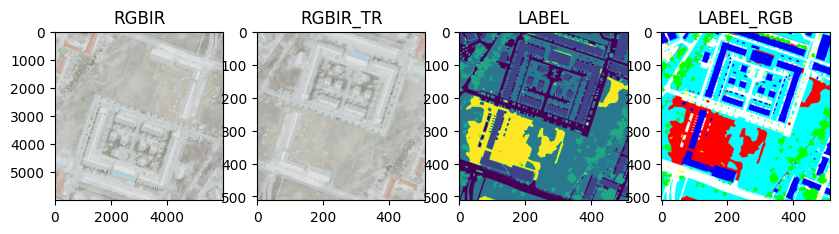

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
RGBIR_folder = '/content/drive/MyDrive/task1/Potsdam/4_Ortho_RGBIR'
LABELS_folder = '/content/drive/MyDrive/task1/Potsdam/5_Labels_all'
total_mean = torch.tensor([86.7113, 92.8464, 86.2080, 98.1235]) # per non far girare ogni volta il loop per il calcolo della media e della std
total_std = torch.tensor([35.2340, 35.0720, 36.5135, 35.6512])
IMAGE_HEIGHT = 512
IMAGE_WIDTH = 512

transform = A.Compose([
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    A.RandomRotate90(),
    A.VerticalFlip(),
    A.HorizontalFlip(),
    A.Normalize(
              mean=(0, 0, 0, 0),
              std=(1, 1, 1, 1),
              max_pixel_value=255.0,
            ),
    ToTensorV2()
])
def label2rgb(mask):
    h, w = mask.shape[0], mask.shape[1]
    mask_rgb = np.zeros(shape=(h, w, 3), dtype=np.uint8)
    mask_convert = mask[np.newaxis, :, :]
    mask_rgb[np.all(mask_convert == 3, axis=0)] = [0, 255, 0]
    mask_rgb[np.all(mask_convert == 0, axis=0)] = [255, 255, 255]
    mask_rgb[np.all(mask_convert == 1, axis=0)] = [0, 0, 255]
    mask_rgb[np.all(mask_convert == 2, axis=0)] = [0, 255, 255]
    mask_rgb[np.all(mask_convert == 4, axis=0)] = [255, 255, 0]
    mask_rgb[np.all(mask_convert == 5, axis=0)] = [255, 0, 0]
    return mask_rgb


dataset_train = PotsdamDataset(RGBIR_folder, LABELS_folder, 'train')
transformed_dataset_train = PotsdamDataset(RGBIR_folder, LABELS_folder, 'train', transform=transform, size=IMAGE_HEIGHT)


#print("image shape: ", dataset_train[0][0].shape, "\nlabel shape:",dataset_train[0][1].shape,"\n\n\n",dataset_train[0],"\n\n\n")
#print("image shape: ", transformed_dataset_train[0][0].shape, "\nlabel shape:",transformed_dataset_train[0][1].shape,"\n\n\n",transformed_dataset_train[0],"\n\n\n")
rgbir = dataset_train[0][0]
transformed_list = transformed_dataset_train[0]
rgbir_tr = transformed_list[0]
label = transformed_list[1]
rgb_label = label2rgb(label)


fig, axs = plt.subplots(1, 4, figsize=(10, 5))

# Plotta le immagini sui rispettivi assi
axs[0].imshow(rgbir.transpose(1, 2, 0))
axs[0].set_title('RGBIR')

axs[1].imshow(rgbir_tr.transpose(1, 2, 0))
axs[1].set_title('RGBIR_TR')

axs[2].imshow(label)
axs[2].set_title('LABEL')

axs[3].imshow(rgb_label)
axs[3].set_title('LABEL_RGB')

plt.show()

# Model


In [4]:
class DoubleConvolution(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConvolution, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels, features=[64,128,256,512]):
        super(UNet, self).__init__()

        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        for feature in features:
            self.downs.append(DoubleConvolution(in_channels, feature))
            in_channels = feature

        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2))
            self.ups.append(DoubleConvolution(feature*2, feature))

        self.bottleneck = DoubleConvolution(features[-1], features[-1]*2)  # Modifica il numero di canali nel bottleneck
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)  # Modifica il numero di canali di output

    def forward(self, x):

        skip_connections = []
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for i in range(0,len(self.ups),2):
            x = self.ups[i](x)
            skip_connection = skip_connections[i//2]

            if x.shape != skip_connection.shape:
                x = F.interpolate(x, size=skip_connection.shape[2:], mode='bilinear', align_corners=True)

            concat_skip = torch.cat((skip_connection,x), dim=1)
            x = self.ups[i+1](concat_skip)

        x = self.final_conv(x)

        return x


# Training e validazione


PARAMETRI

In [6]:
LEARNING_RATE = 0.001
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
RGBIR_folder = '/content/drive/MyDrive/task1/Potsdam/4_Ortho_RGBIR'
LABELS_folder = '/content/drive/MyDrive/task1/Potsdam/5_Labels_all'
BATCH_SIZE = 4
LOAD_MODEL = True
NUM_EPOCHS = 15
NUM_CLASSES = 6
NUM_WORKERS = 2
IMAGE_HEIGHT = 384
IMAGE_WIDTH = 384
best_mIoU = 0.0
save_best_model = True
train_losses_global = []
val_losses_global = []
val_iou_global = []

UTILITIES

In [7]:
def calculate_iou(predictions, targets, num_classes):
    """
    Funzione per il calcolo dell'IoU per ogni classe.

    Args:
        predictions: Tensore con le predizioni del modello (batch_size, num_classes, altezza, larghezza).
        targets: Tensore con le label di ground truth (batch_size, altezza, larghezza).
        num_classes: Numero di classi.

    Returns:
        Lista con l'IoU per ogni classe.
    """

    ious_per_class = []
    for cls in range(num_classes):
        intersection = torch.logical_and(predictions == cls, targets == cls).sum().float()
        union = torch.logical_or(predictions == cls, targets == cls).sum().float()
        iou = (intersection + 1e-6) / (union + 1e-6)  # Aggiungi epsilon per evitare divisione per zero
        ious_per_class.append(iou.item())
    return ious_per_class



def calculate_miou(predictions, targets, num_classes):
    """
    Funzione per il calcolo dell'mIoU (mean IoU) per un batch.

    Args:
        predictions: Tensore con le predizioni del modello (batch_size, num_classes, altezza, larghezza).
        targets: Tensore con le label di ground truth (batch_size, altezza, larghezza).
        num_classes: Numero di classi.

    Returns:
        mIoU per il batch.
    """

    ious_per_batch = calculate_iou(predictions, targets, num_classes)
    miou = sum(ious_per_batch) / num_classes
    return miou





def plot_metrics(train_losses, val_losses, val_iou, val_miou, val_accuracy, figsize=(12, 6)):
    """
    Plots train and validation losses, IoU, mIoU, and accuracy.

    Args:
        train_losses (list): List of train losses for each epoch.
        val_losses (list): List of validation losses for each epoch.
        val_iou (list): List of validation IoU values for each epoch.
        val_miou (list): List of validation mIoU values for each epoch.
        val_accuracy (list): List of validation accuracy values for each epoch.
        figsize (tuple, optional): Figure size. Defaults to (12, 6).
    """

    epochs = range(len(train_losses))  # Calculate epochs based on train losses

    # Plot train and validation losses
    plt.figure(figsize=figsize)
    plt.plot(epochs, train_losses, label='Train Loss', color='blue')
    plt.plot(epochs, val_losses, label='Validation Loss', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Train and Validation Losses')
    plt.grid(True)

    # Plot validation IoU and mIoU
    plt.figure(figsize=figsize)
    plt.plot(epochs, val_iou, label='Validation IoU', color='green')
    plt.plot(epochs, val_miou, label='Validation mIoU', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('IoU')
    plt.legend()
    plt.title('Validation IoU and mIoU')
    plt.grid(True)

    # Plot validation accuracy
    plt.figure(figsize=figsize)
    plt.bar(epochs, val_accuracy, color='purple', alpha=0.7)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Overall Accuracy per Epoch')
    plt.grid(axis='y')
    for i, acc in enumerate(val_accuracy):
        plt.text(i + 1, acc + 0.01, f'{acc:.4f}', ha='center', va='bottom')

    # Show all plots
    plt.show()


def calculate_overall_accuracy(predictions, targets):
    """
    Funzione per il calcolo dell'Overall Accuracy.

    Args:
        predictions: Tensore con le predizioni del modello (batch_size, altezza, larghezza).
        targets: Tensore con le label di ground truth (batch_size, altezza, larghezza).

    Returns:
        Overall Accuracy per il batch.
    """

    correct = (predictions == targets).sum().item()
    total = targets.numel()
    accuracy = correct / total
    return accuracy

TRAIN AND EVALUATION

In [14]:
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ExponentialLR
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import cv2

def train(model, loader, criterion, optimizer, device, scaler):
    model.train()
    running_loss = 0.0
    for inputs, targets in tqdm(loader):
        inputs, targets = inputs.to(device), targets.to(device, dtype=torch.long)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item() * inputs.size(0)
    return running_loss / len(loader.dataset)

def evaluate(model, loader, device, num_classes):
    model.eval()
    total_loss = 0.0
    total_iou = 0.0
    batch_miou = []
    total_accuracy = 0.0
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for inputs, targets in tqdm(loader):
            inputs, targets = inputs.to(device), targets.to(device, dtype=torch.long)
            outputs = model(inputs)
            probabilities = F.softmax(outputs, dim=1)
            predictions = probabilities.argmax(dim=1)
            ious_per_batch = calculate_iou(predictions, targets, num_classes)
            miou = calculate_miou(predictions, targets, num_classes)
            total_accuracy = calculate_overall_accuracy(predictions, targets)
            loss = criterion(outputs, targets)
            total_loss += loss.item() * inputs.size(0)
            total_iou += sum(ious_per_batch) / num_classes * inputs.size(0)
            batch_miou.append(miou)
    # Calculate average metrics
    avg_loss = total_loss / len(loader.dataset)
    avg_iou = total_iou / len(loader.dataset)
    avg_miou = torch.tensor(batch_miou).mean()
    avg_accuracy = total_accuracy / len(loader.dataset)

    # Return the calculated metrics
    return avg_loss, avg_iou, avg_miou, avg_accuracy


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_transform = A.Compose([
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    A.RandomRotate90(),
    A.VerticalFlip(),
    A.HorizontalFlip(),
    A.Normalize(
              mean=(0, 0, 0, 0),
              std=(1, 1, 1, 1),
              max_pixel_value=255.0,
            ),
   ToTensorV2(always_apply=True),
        ]
    )
val_transform = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Normalize(
                mean=(0, 0, 0, 0),
                std=(1, 1, 1, 1),
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ]
)

model = UNet(in_channels=4, out_channels=6).to(device)

if LOAD_MODEL:
      loaded_data = torch.load('model_and_metrics.pth')

      model.load_state_dict(loaded_data['model_state_dict'])
      train_losses = loaded_data['train_losses']
      val_losses = loaded_data['val_losses']
      val_iou = loaded_data['val_iou']
      val_miou = loaded_data['val_miou']
      val_accuracy = loaded_data['val_accuracy']
      best_miou = loaded_data['best_miou']
      best_epoch = loaded_data['best_epoch']
else:
      train_losses = []
      val_losses = []
      val_iou = []
      val_miou = []
      val_accuracy = []

      best_miou = 0.0
      best_epoch = 0

params_to_update = model.parameters()
# Definisci l'ottimizzatore
optimizer = optim.Adam(params_to_update, lr=LEARNING_RATE)
scheduler = ExponentialLR(optimizer, gamma=0.95)
criterion = nn.CrossEntropyLoss()
scaler = torch.cuda.amp.GradScaler()

transformed_dataset_train = PotsdamDataset(RGBIR_folder, LABELS_folder, 'train', transform=train_transform, size=IMAGE_HEIGHT)
transformed_dataset_val = PotsdamDataset(RGBIR_folder, LABELS_folder, 'val', transform=val_transform, size=IMAGE_HEIGHT)

train_loader = DataLoader(transformed_dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(transformed_dataset_val, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)


for epoch in range(NUM_EPOCHS):
    # Fase di addestramento
    train_loss = train(model, train_loader, criterion, optimizer, device, scaler)
    train_losses.append(train_loss)

    # Fase idi validazione
    val_loss, val_iou_value, val_miou_value, val_accuracy_value = evaluate(model, val_loader, device, NUM_CLASSES)
    val_losses.append(val_loss)
    val_iou.append(val_iou_value)
    val_miou.append(val_miou_value)
    val_accuracy.append(val_accuracy_value)

    print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation IoU: {val_iou_value:.4f}, Validation mIoU: {val_miou_value:.4f}, Validation Accuracy: {val_accuracy_value:.4f}')

    # Salvataggio del modello con la migliore mIoU
    if save_best_model and val_miou_value > best_miou:
        best_miou = val_miou_value
        best_epoch = epoch
        saved_data = {
          'model_state_dict': model.state_dict(),
          'train_losses': train_losses,
          'val_losses': val_losses,
          'val_iou': val_iou,
          'val_miou': val_miou,
          'val_accuracy': val_accuracy,
          'best_miou': best_miou,
          'best_epoch': best_epoch
        }
        save_path = 'model_and_metrics.pth'
        torch.save(saved_data, save_path)

    scheduler.step()

# Riepilogo
print(f'Miglior mIoU: {best_miou:.4f} all\'epoca {best_epoch}')



  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


  0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Epoch [1/15], Train Loss: 1.2162, Validation Loss: 6.4883, Validation IoU: 0.0490, Validation mIoU: 0.0496, Validation Accuracy: 0.0492


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


  0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Epoch [2/15], Train Loss: 1.1085, Validation Loss: 2.7726, Validation IoU: 0.0337, Validation mIoU: 0.0329, Validation Accuracy: 0.0260


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


  0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Epoch [3/15], Train Loss: 1.0006, Validation Loss: 3.6896, Validation IoU: 0.0845, Validation mIoU: 0.0842, Validation Accuracy: 0.0453


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


  0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Epoch [4/15], Train Loss: 0.9681, Validation Loss: 2.2532, Validation IoU: 0.0642, Validation mIoU: 0.0599, Validation Accuracy: 0.0319


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


  0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Epoch [5/15], Train Loss: 0.9672, Validation Loss: 1.9075, Validation IoU: 0.1133, Validation mIoU: 0.1099, Validation Accuracy: 0.0446


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


  0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Epoch [6/15], Train Loss: 0.9217, Validation Loss: 1.6188, Validation IoU: 0.1740, Validation mIoU: 0.1721, Validation Accuracy: 0.0687


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Exception ig

  0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Epoch [7/15], Train Loss: 0.9228, Validation Loss: 1.1639, Validation IoU: 0.2750, Validation mIoU: 0.2689, Validation Accuracy: 0.0862


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


  0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Epoch [8/15], Train Loss: 0.9175, Validation Loss: 1.3131, Validation IoU: 0.2464, Validation mIoU: 0.2385, Validation Accuracy: 0.0792


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


  0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Epoch [9/15], Train Loss: 0.8843, Validation Loss: 1.1098, Validation IoU: 0.3105, Validation mIoU: 0.3032, Validation Accuracy: 0.0901


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


  0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Epoch [10/15], Train Loss: 0.8656, Validation Loss: 1.0374, Validation IoU: 0.3282, Validation mIoU: 0.3220, Validation Accuracy: 0.0947


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


  0%|          | 0/2 [00:00<?, ?it/s]


/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Exception i

Epoch [11/15], Train Loss: 0.8398, Validation Loss: 1.0935, Validation IoU: 0.3136, Validation mIoU: 0.3025, Validation Accuracy: 0.0883


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


  0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Epoch [12/15], Train Loss: 0.8235, Validation Loss: 1.0093, Validation IoU: 0.3607, Validation mIoU: 0.3557, Validation Accuracy: 0.0979


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


  0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Epoch [13/15], Train Loss: 0.8302, Validation Loss: 1.0072, Validation IoU: 0.3622, Validation mIoU: 0.3534, Validation Accuracy: 0.0966


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


  0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Epoch [14/15], Train Loss: 0.8217, Validation Loss: 0.9905, Validation IoU: 0.3610, Validation mIoU: 0.3525, Validation Accuracy: 0.0966


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


  0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Epoch [15/15], Train Loss: 0.8245, Validation Loss: 1.2448, Validation IoU: 0.2980, Validation mIoU: 0.2922, Validation Accuracy: 0.0825
Miglior mIoU: 0.3557 all'epoca 11


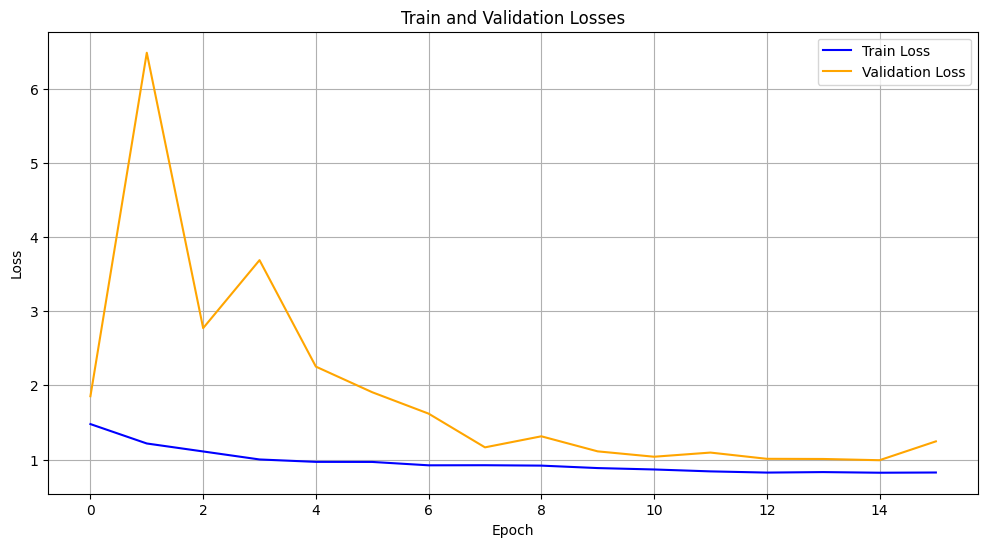

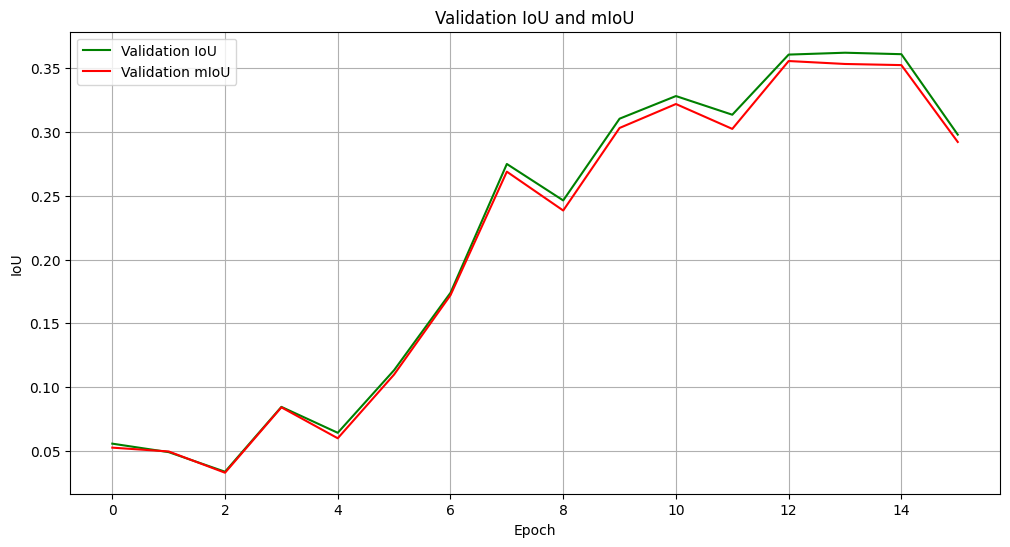

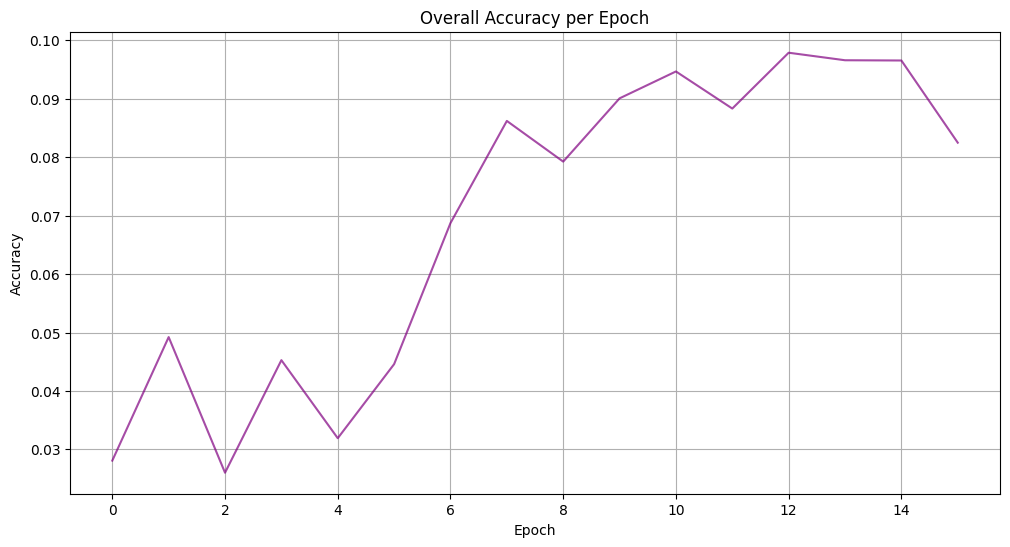

In [15]:
def plot_metrics(train_losses, val_losses, val_iou, val_miou, val_accuracy, figsize=(12, 6)):
    """
    Plots train and validation losses, IoU, mIoU, and accuracy.

    Args:
        train_losses (list): List of train losses for each epoch.
        val_losses (list): List of validation losses for each epoch.
        val_iou (list): List of validation IoU values for each epoch.
        val_miou (list): List of validation mIoU values for each epoch.
        val_accuracy (list): List of validation accuracy values for each epoch.
        figsize (tuple, optional): Figure size. Defaults to (12, 6).
    """

    epochs = range(len(train_losses))  # Calculate epochs based on train losses

    # Plot train and validation losses
    plt.figure(figsize=figsize)
    plt.plot(epochs, train_losses, label='Train Loss', color='blue')
    plt.plot(epochs, val_losses, label='Validation Loss', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Train and Validation Losses')
    plt.grid(True)

    # Plot validation IoU and mIoU
    plt.figure(figsize=figsize)
    plt.plot(epochs, val_iou, label='Validation IoU', color='green')
    plt.plot(epochs, val_miou, label='Validation mIoU', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('IoU')
    plt.legend()
    plt.title('Validation IoU and mIoU')
    plt.grid(True)

    # Plot validation accuracy
    plt.figure(figsize=figsize)
    plt.plot(epochs, val_accuracy, color='purple', alpha=0.7)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Overall Accuracy per Epoch')
    plt.grid(True)

    # Show all plots
    plt.show()
plot_metrics(train_losses, val_losses, val_iou, val_miou, val_accuracy)

# Plot di predizioni sul test set


  0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


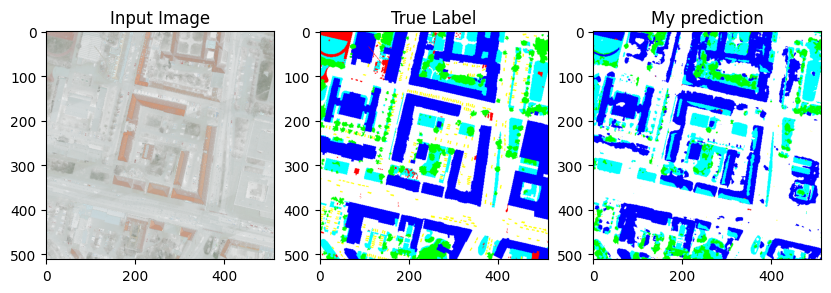

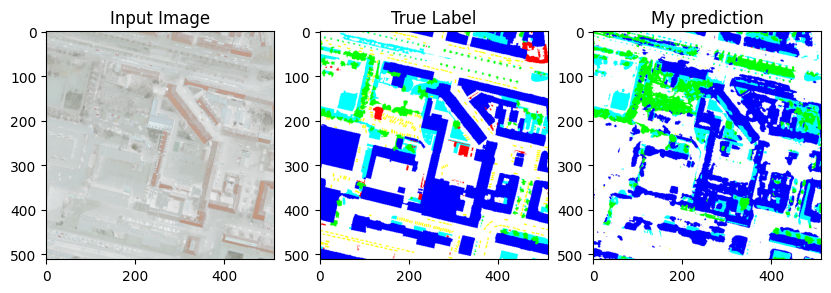

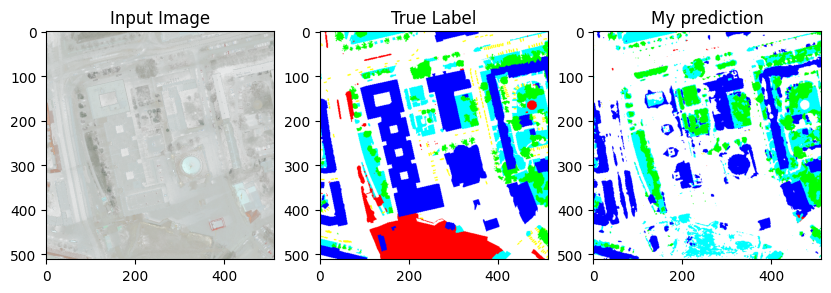

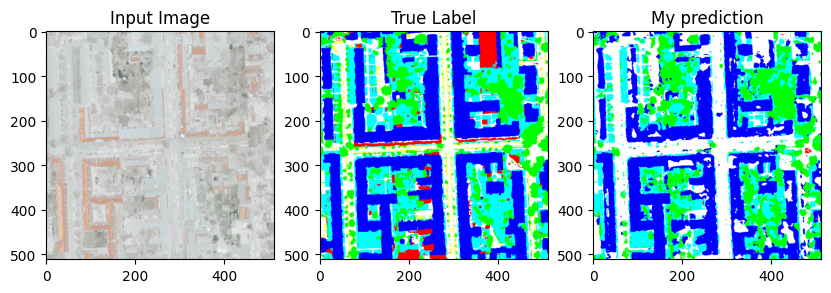

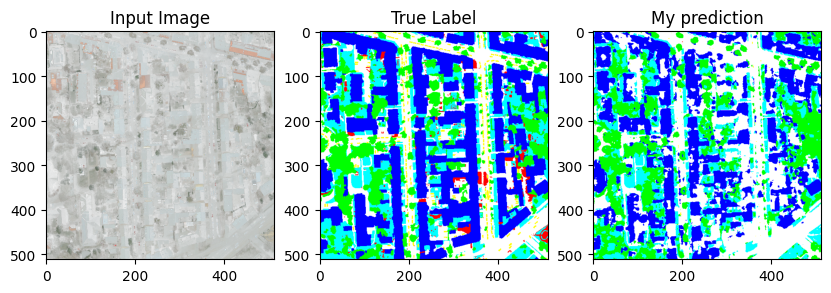

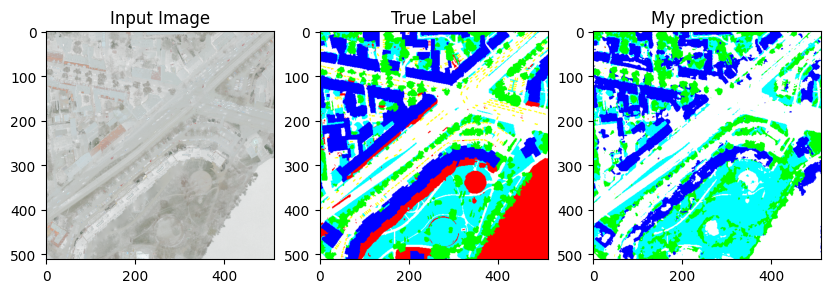

In [18]:
# Load del modello addestrato
model = UNet(in_channels=4,out_channels=6)
model.load_state_dict(torch.load('model_best_miou.pth'))
model.to(device)
test_transform = A.Compose([
    A.Resize(height=512, width=512),
    A.Normalize(
              mean=(0, 0, 0, 0),
              std=(1, 1, 1, 1),
              max_pixel_value=255.0,
            ),
   ToTensorV2(always_apply=True),
        ]
    )

model.eval()

def label2rgb(mask):
    h, w = mask.shape[0], mask.shape[1]
    mask_rgb = np.zeros(shape=(h, w, 3), dtype=np.uint8)
    mask_convert = mask[np.newaxis, :, :]
    mask_rgb[np.all(mask_convert == 3, axis=0)] = [0, 255, 0]
    mask_rgb[np.all(mask_convert == 0, axis=0)] = [255, 255, 255]
    mask_rgb[np.all(mask_convert == 1, axis=0)] = [0, 0, 255]
    mask_rgb[np.all(mask_convert == 2, axis=0)] = [0, 255, 255]
    mask_rgb[np.all(mask_convert == 4, axis=0)] = [255, 255, 0]
    mask_rgb[np.all(mask_convert == 5, axis=0)] = [255, 0, 0]
    return mask_rgb



dataset_test = PotsdamDataset(RGBIR_folder, LABELS_folder, 'test', transform=test_transform, size=IMAGE_HEIGHT)

test_loader = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

for inputs, targets in tqdm(test_loader):
    inputs = inputs.to(device)
    targets = targets.to(device, dtype=torch.long)

    with torch.no_grad():
      outputs = model(inputs)
      probabilities = F.softmax(outputs, dim=1)  # Applica la funzione softmax lungo l'asse delle classi
      _, predicted = torch.max(probabilities, 1)  # Trova l'indice della classe con probabilità massima

    for i in range(len(inputs)):
        input_image = inputs[i].permute(1, 2, 0).cpu().numpy()
        true_label = targets[i].cpu().numpy()
        predicted_label = predicted[i].cpu().numpy()

        plt.figure(figsize=(10, 5))

        # Plot dell'immagine di input
        plt.subplot(1, 3, 1)
        plt.imshow(input_image)
        plt.title('Input Image')

        # Plot dell'etichetta reale
        plt.subplot(1, 3, 2)
        plt.imshow(label2rgb(true_label))
        plt.title('True Label')

        # Plot dell'etichetta predetta
        plt.subplot(1, 3, 3)
        plt.imshow(label2rgb(predicted_label))
        plt.title('My prediction')

        plt.show()
